# Project Overview

This project focuses on **text summarization** using two approaches: a traditional **Seq2Seq model** with LSTM and a **Transformer-based model**. The goal is to see how each model performs and understand the difference between step-by-step sequence processing and attention-based processing.

### Steps in the Project
1. **Dataset Preparation**  
   - Load the XSum dataset with articles and summaries.  
   - Tokenize and pad sequences so they can be fed into the models.

2. **Seq2Seq Model (LSTM)**  
   - Build an encoder-decoder model.  
   - Train it to generate summaries from the input articles.  
   - Use attention to help the model focus on relevant parts of the input.

3. **Transformer Model**  
   - Build a Transformer-based encoder-decoder model.  
   - Use self-attention to capture relationships between all tokens.  
   - Train on the same dataset to generate summaries.

4. **Comparison**  
   - Compare the two models using metrics like ROUGE.  
   - Look at differences in summary quality, speed, and how well they handle long sequences.

# Seq2Seq and Encoder-Decoder

## What is a Seq2Seq Model
A sequence-to-sequence (Seq2Seq) model is designed to take an input sequence and produce an output sequence. It’s widely used in tasks like machine translation, text summarization, and chatbots.

**Example:**  
Input: "Hello, how are you?"  
Output: "Ciao, come stai?"

## Encoder-Decoder Architecture (Expanded)

A typical Seq2Seq model has two main parts: the **encoder** and the **decoder**. The design allows the model to process sequences of variable length.  

### Encoder
The encoder reads the input sequence and compresses it into a set of hidden states or a context vector. This vector captures the important information from the input and has a fixed size, though it does not need to match the decoder's size. The hidden states can either be passed as a whole to the decoder or connected at every decoding step.  

At each step, the encoder updates its hidden state based on the previous hidden state and the current input. In mathematical terms, for a simple RNN:

$$
H_t^{encoder} = \phi(W_{HH} \cdot H_{t-1}^{encoder} + W_{HX} \cdot X_t)
$$

Where:  
- $H_t^{encoder}$ = hidden state at time $t$ in the encoder  
- $X_t$ = input at time $t$  
- $W_{HH}$ = weight matrix connecting hidden states  
- $W_{HX}$ = weight matrix connecting input to hidden states  
- $\phi$ = activation function (e.g., tanh or ReLU)

### Decoder
The decoder generates the output sequence one token at a time. Its initial hidden state is set to the final hidden state of the encoder. For a simple RNN decoder:

$$
H_t^{decoder} = \phi(W_{HH} \cdot H_{t-1}^{decoder} + W_{HY} \cdot Y_{t-1})
$$

The output at each step is computed as:

$$
Y_t = W_{HY} \cdot H_t^{decoder}
$$

Where:  
- $H_t^{decoder}$ = hidden state at time $t$ in the decoder  
- $Y_t$ = output at time $t$  
- $W_{HY}$ = weight matrix connecting decoder hidden state to output  

### Implementation Notes
- Encoders and decoders are typically implemented with **RNNs, LSTMs, or GRUs**.  
- The input and output vectors are of fixed size, but the encoder and decoder can have different hidden dimensions.  
- During training, **teacher forcing** is often used, providing the correct previous token to the decoder instead of its own prediction.  


## Tokenization

Before feeding text into a Seq2Seq or Transformer model, the raw text must be converted into numerical form.  
This is done through **tokenization**, which splits text into smaller units (tokens) such as words or subwords.  

Each token is then mapped to a unique integer using a **vocabulary** built from the dataset.  
The model processes these integers rather than the raw text.

**Example:**

Input text: `"Transformers improve summarization."`  
Tokens: `["transformers", "improve", "summarization", "."]`  
Token IDs: `[201, 57, 1342, 4]`

### Why Tokenization Matters
- Converts variable-length text into consistent, model-readable sequences.  
- Helps capture word frequency and context relationships.  
- Reduces vocabulary size when using subword tokenization (e.g., Byte Pair Encoding).  

In this project, tokenization is part of preprocessing and includes:
- **Lowercasing** the text  
- **Removing special characters and URLs**  
- **Splitting into tokens by spaces**  
- Adding **start (`sostok`)** and **end (`eostok`)** tokens to mark summary boundaries  

```python
def tokenize_texts(texts):
    # Clean text and split into tokens by spaces
    return [' '.join(clean_text(t).split()) for t in texts]

# Example from preprocessing step
processed_text = tokenize_texts(df['text'])
processed_summary = ['sostok ' + s + ' eostok' for s in tokenize_texts(df['summary'])]

```
After tokenization, sequences will later be converted to integer IDs, padded or truncated to a fixed length


## Attention
In a basic Seq2Seq model, the encoder squashes the whole input document into a single **context vector**. That works okay for short texts, but with longer documents the decoder can easily “forget” important details.

This is where an **attention mechanism** comes in. Instead of just using the encoder’s last hidden state, the decoder can look at **all the hidden states** of the encoder. At each step of generating the summary, it calculates **weights** for each input token to figure out which parts of the text are most relevant.

Using attention usually improves the quality of the summaries, since the model can focus on the right parts of the input at the right time.  
This idea is also the core of **Transformers**, which take it further with **self-attention**, letting all tokens interact at once and handle long sequences much better.

### How Attention Works 
The key idea of attention is that the decoder doesn't have to rely solely on the last hidden state of the encoder. Instead, it looks at **all the hidden states** of the encoder and decides how much to focus on each one when predicting the next token.


1. **Score Calculation**  
   - For each decoder step, the model calculates a **score** for every encoder hidden state.  
   - This score measures how relevant each input token is to the current token being generated.

2. **Softmax to Get Weights**  
   - The scores are passed through a **softmax function**, turning them into weights that sum to 1.  
   - These weights tell the decoder how much attention to pay to each input token.

3. **Context Vector**  
   - The encoder hidden states are combined using these attention weights to form a **dynamic context vector**.  
   - Unlike the single context vector in vanilla Seq2Seq, this vector changes at every decoder step depending on what the model is currently generating.

4. **Decoder Output**  
   - The context vector is then fed into the decoder (along with the previous token) to predict the next token.  
   - This allows the decoder to “focus” on the most relevant parts of the input for each step.

**Intuition:**  
Think of it like reading a paragraph and highlighting the important words as you write a summary. The decoder “looks back” at all the input words and decides which ones matter most at each step.



# Transformers
Transformers can be seen as an evolution of Seq2Seq models, as they replace step-by-step LSTM/GRU processing with parallel attention-based mechanisms, allowing better handling of long sequences. They rely entirely on **attention mechanisms** to understand relationships between all tokens in the input at once.

### Key Components
- **Self-Attention:** Allows the model to weigh the importance of each token in the sequence relative to the others. This helps capture long-range dependencies better than RNNs.
- **Encoder-Decoder Structure:** Like Seq2Seq models, Transformers have an encoder that processes the input and a decoder that generates the output. Both use layers of self-attention and feed-forward networks.
- **Positional Encoding:** Since Transformers don’t process tokens sequentially, they add positional information so the model knows the order of tokens.

### Advantages over LSTM/GRU Seq2Seq
- Can process sequences **in parallel**, speeding up training.
- Handle **long sequences** more effectively with attention.
- Easier to scale to large datasets and very deep models.

### Use Cases
Transformers are the backbone of many state-of-the-art models for tasks such as:
- Machine translation (e.g., T5, MarianMT)
- Text summarization (e.g., BART, Pegasus)
- Question answering and chatbots (e.g., GPT, BERT-based models)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# **Data preparation**

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)

summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
summary_more = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

print(summary.shape)
print(summary_more.shape)

(4514, 6)
(98401, 2)


In [3]:
summary.head(1)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.,"The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman and Diu administration a day apart. The circular was withdrawn through a one-line order issued late in the evening by the UT?s department of personnel and administrative reforms.?The circular is ridiculous. There are sensitivities involved. How can the government dictate who I should tie rakhi to? We should maintain the professionalism of a workplace? an official told Hindustan Times earlier in the day. She refused to be identified.The notice was issued on Daman and Diu administrator and former Gujarat home minister Praful Kodabhai Patel?s direction, sources said.Rakshabandhan, a celebration of the bond between brothers and sisters, is one of several Hindu festivities and rituals that are no longer confined of private, family affairs but have become tools to push politic al ideologies.In 2014, the year BJP stormed to power at the Centre, Rashtriya Swayamsevak Sangh (RSS) chief Mohan Bhagwat said the festival had ?national significance? and should be celebrated widely ?to protect Hindu culture and live by the values enshrined in it?. The RSS is the ideological parent of the ruling BJP.Last year, women ministers in the Modi government went to the border areas to celebrate the festival with soldiers. A year before, all cabinet ministers were asked to go to their constituencies for the festival."


In [4]:

summary_more.head(1)

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."


In [5]:
summary = summary.iloc[:, 0:6]
summary_more = summary_more.iloc[:, 0:2]

# To increase the intake of possible text values to build a reliable model
summary['text'] = (
    summary['author'] + ' ' +
    summary['date'] + ' ' +
    summary['read_more'] + ' ' +
    summary['text'] + ' ' +
    summary['ctext']
)


df = pd.DataFrame()

df['text'] = pd.concat([summary_more['text'], summary['text']], ignore_index=True)
df['summary'] = pd.concat([summary_more['headlines'], summary['headlines']], ignore_index=True)

print(df.shape)
df.head(2)

(102915, 2)


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",Delhi techie wins free food from Swiggy for one year on CRED


In [6]:
import re

def clean_text(text):
    """
    - converts to lowercase
    - removes special characters
    - replaces URLs with domain names
    - reduces multiple spaces
    """
    text = str(text).lower()
    text = re.sub(r'https?://([^/\s]+).*', r'\1', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Tokenization: split text by spaces
def tokenize_texts(texts):
    return [' '.join(clean_text(t).split()) for t in texts]


processed_text = tokenize_texts(df['text'])
processed_summary = ['_START_ ' + s + ' _END_' for s in tokenize_texts(df['summary'])]

df['cleaned_text'] = pd.Series(processed_text)
df['cleaned_summary'] = pd.Series(processed_summary)

In [7]:
print(f"NaN dropped: {df.isna().sum().sum()}")

df = df.dropna(subset=['text'])

print(df.shape)

NaN dropped: 118
(102797, 4)


In [8]:
df.head(2)

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",upGrad learner switches to career in ML & Al with 90% salary hike,saurav kant an alumnus of upgrad and iiit b s pg program in machine learning and artificial intelligence was a sr systems engineer at infosys with almost 5 years of work experience the program and upgrad s 360 degree career support helped him transition to a data scientist at tech mahindra with 90 salary hike upgrad s online power learning has powered 3 lakh careers,_START_ upgrad learner switches to career in ml al with 90 salary hike _END_
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",Delhi techie wins free food from Swiggy for one year on CRED,kunal shah s credit card bill payment platform cred gave users a chance to win free food from swiggy for one year pranav kaushik a delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more,_START_ delhi techie wins free food from swiggy for one year on cred _END_


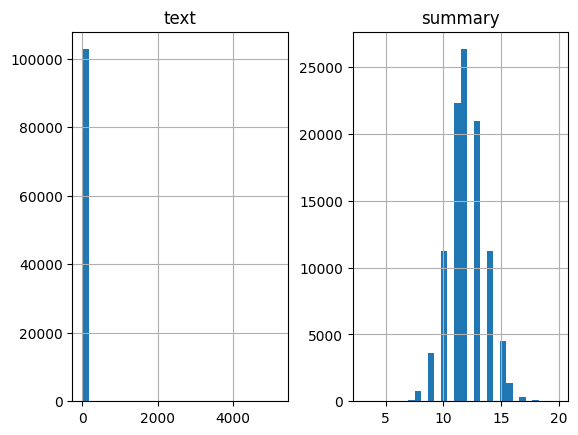

In [9]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 30)
plt.show()

In [10]:
cnt = 0
for i in df['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(f"Percentage of texts with less than 100 words : {cnt / len(df['cleaned_text'])}")

Percentage of texts with less than 100 words : 0.9988715623996809


In [11]:
max_text_len = 100
max_summary_len = 15

df['cleaned_text'] = df['cleaned_text'].astype(str)
df['cleaned_summary'] = df['cleaned_summary'].astype(str)

mask = (df['cleaned_text'].str.split().str.len() <= max_text_len) & \
       (df['cleaned_summary'].str.split().str.len() <= max_summary_len)

df = df.loc[mask].reset_index(drop=True)

# Add start and end tokens to each summary
df['summary'] = df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

df.head(2)

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",sostok upGrad learner switches to career in ML & Al with 90% salary hike eostok,saurav kant an alumnus of upgrad and iiit b s pg program in machine learning and artificial intelligence was a sr systems engineer at infosys with almost 5 years of work experience the program and upgrad s 360 degree career support helped him transition to a data scientist at tech mahindra with 90 salary hike upgrad s online power learning has powered 3 lakh careers,_START_ upgrad learner switches to career in ml al with 90 salary hike _END_
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",sostok Delhi techie wins free food from Swiggy for one year on CRED eostok,kunal shah s credit card bill payment platform cred gave users a chance to win free food from swiggy for one year pranav kaushik a delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more,_START_ delhi techie wins free food from swiggy for one year on cred _END_


# **Tokenization**

This block prepares the text data for a sequence-to-sequence model:

- **Split dataset**: Separates `text` and `summary` into training and validation sets to evaluate model performance on unseen data.  
- **Initialize tokenizers**: Converts words into integer indices, which neural networks can process.  
- **Analyze rare words**: Computes the percentage of words appearing less than `thresh` times to identify infrequent words that might add noise.  
- **Limit vocabulary to frequent words**: Reduces vocabulary size by ignoring rare words, which improves training efficiency and prevents overfitting.  
- **Convert texts to sequences**: Maps each word in the texts to its corresponding integer index.  
- **Pad sequences**: Ensures all sequences have the same length, necessary for batch processing in neural networks.  
- **Compute final vocabulary size**: Includes the padding token to correctly define the input dimension for the model embedding layer.

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train, x_val, y_train, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

2025-10-10 19:19:21.855511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760123962.107606      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760123962.173905      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
thresh = 5

def rare_word_stats(tokenizer, thresh):
    """Return total and rare word counts for a given tokenizer."""
    total_cnt = len(tokenizer.word_counts)
    rare_cnt = sum(1 for word, count in tokenizer.word_counts.items() if count < thresh)
    return total_cnt, rare_cnt


x_tot_cnt, x_cnt = rare_word_stats(x_tokenizer, thresh)
y_tot_cnt, y_cnt = rare_word_stats(y_tokenizer, thresh)

print(f"% of rare words in X vocabulary: {(x_cnt / x_tot_cnt) * 100:.2f}%")
print(f"% of rare words in Y vocabulary: {(y_cnt / y_tot_cnt) * 100:.2f}%")

% of rare words in X vocabulary: 68.39%
% of rare words in Y vocabulary: 68.00%


In [14]:
# Create tokenizers considering only frequent words
x_tokenizer = Tokenizer(num_words = x_tot_cnt - x_cnt) 
x_tokenizer.fit_on_texts(list(x_train))

y_tokenizer = Tokenizer(num_words=y_tot_cnt-y_cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text to sequences of integers
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad sequences
x_train = pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Vocab. size (+1 for padding token)
x_voc_size = x_tokenizer.num_words + 1
y_voc_size = y_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc_size))
print("Size of vocabulary in Y = {}".format(y_voc_size))

Size of vocabulary in X = 36564
Size of vocabulary in Y = 13740


In [15]:
# Finally remove from the dataset empty summaries that contain only the 'START' and 'END' tokens

x_train = x_train[np.sum(y_train != 0, axis=1) > 2]
y_train = y_train[np.sum(y_train != 0, axis=1) > 2]

x_val = x_val[np.sum(y_val != 0, axis=1) > 2]
y_val = y_val[np.sum(y_val != 0, axis=1) > 2]
